In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, Matern, RBF
from sklearn.multioutput import MultiOutputRegressor
from sklearn.multioutput import RegressorChain
from sklearn.metrics import mean_squared_error
from datetime import datetime as dt
import datetime

import warnings
warnings.filterwarnings(action="ignore", category=UserWarning)

In [ ]:
def read_data():
  # Load CSV into dataframe and format
  df = pd.read_csv('final_daily.csv')
  df['date']=pd.to_datetime(df['date'])
  df=df[df['date']<datetime.datetime(2023,1,1)]

  variable = 'demand'

  VAL_PERC = 0.30

  n_train = int(len(df[:-365]) * (1 - VAL_PERC))

  dataframe_train = df[variable][0:-365]
  train_df = dataframe_train.values.reshape(-1, 1)

  dataframe_test = df[variable][-365:]
  test_df = dataframe_test.values.reshape(-1, 1)

  dataframe_dataset = df[variable][0:df.shape[0]]
  dataset= dataframe_dataset.values.reshape(-1, 1)

  return df, train_df, test_df, dataset

In [ ]:
def to_sequences(dataset, seq_size): # seq_size is Number of time steps to look back 
                                       #Larger sequences (look further back) may improve forecasting.
    x = []
    y = []

    for i in range(len(dataset)-seq_size-1):
        window = dataset[i:(i+seq_size), :]
        x.append(window)
        y.append(dataset[i+seq_size, :])
    print(np.array(x).shape)
        
    return np.array(x),np.array(y)

In [ ]:
df, train, test, dataset = read_data()

In [ ]:
seq_size = 10

# convert dataset into input/output
trainX, trainY = to_sequences(train, seq_size)
testX, testY = to_sequences(test, seq_size)

(720, 10, 1)
(354, 10, 1)


In [ ]:
# make prediction on validation
start = dt.now()

kernel = DotProduct() + WhiteKernel()

model = GaussianProcessRegressor(
    kernel=kernel,
    random_state=234
    )

# model_fit = MultiOutputRegressor(model).fit(trainX[:, :, 0], trainY[:, 0].reshape(-1, 1))
# prediction = model_fit.predict(testX[:, :, 0])

model_fit = MultiOutputRegressor(model).fit(trainX[:, :, 0], trainY[:, 0].reshape(-1, 1))
prediction = model_fit.predict(testX[:, :, 0])

# for i in range(1, 2):
#   model_fit = RegressorChain(model).fit(trainX[:, :, i], trainY[:, i].reshape(-1, 1))
#   pred_tmp = model_fit.predict(testX[:, :, i])
#   prediction = np.hstack((prediction, pred_tmp))

running_secs = (dt.now() - start).microseconds
print(running_secs)
#prediction = np.array(prediction)

389296


In [ ]:
print(running_secs * (1e-6))

0.389296


In [ ]:
prediction.shape

(354, 1)

In [ ]:
pred = pd.DataFrame(prediction)

In [ ]:
def mae(y_hat, y):
    return float(np.abs(y_hat - y).mean())


def mape(y_hat, y):
    return 100 * np.abs((y_hat - y) / (y + 1e-8)).mean()


def mse(y_hat, y):
    return np.square(y_hat - y).mean()


def rmse(y_hat, y):
    return float(np.sqrt(mse(y_hat, y)))

In [ ]:
# #check rmse
# print('rmse is : ', rmse(pred, testY))

In [ ]:
# # RMSE for default prediction
# print(len(df['HOEP'][len(df)//2 + 1:]))
# print(len(df['Hour 1 Predispatch'][len(df)//2 + 1:-1])))
# print(rmse(df['HOEP'][len(df)//2 + 1:], df['Hour 1 Predispatch'][len(df)//2 + 1:-1]))

In [ ]:
def plotting (dataset, trainPredict, valPredict):
# shift train predictions for plotting
#we must shift the predictions so that they align on the x-axis with the original dataset. 
    trainPredictPlot = np.empty_like(dataset).astype('float64')
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[seq_size-1:len(trainPredict)+seq_size-1, :] = trainPredict

    # shift val predictions for plotting
    valPredictPlot = np.empty_like(dataset).astype('float64')
    valPredictPlot[:, :] = np.nan
    # valPredictPlot[len(trainPredict)+(seq_size*2)-2:, :] = valPredict
    valPredictPlot[len(trainPredict)+seq_size+1:, :] = valPredict


    # plot baseline and predictions
    mpl.rcParams['figure.dpi'] = 300
    plt.plot(dataset, color='k', label='dataset')
    plt.plot(trainPredictPlot, color='b', label='train', linestyle='dashed')
    plt.plot(valPredictPlot, color='g', label='Val', linestyle='dashed')
    plt.legend(loc="upper left")
    plt.title("Prediction")
    plt.xlabel("Time")
    plt.ylabel("Count")
    plt.show()

    return

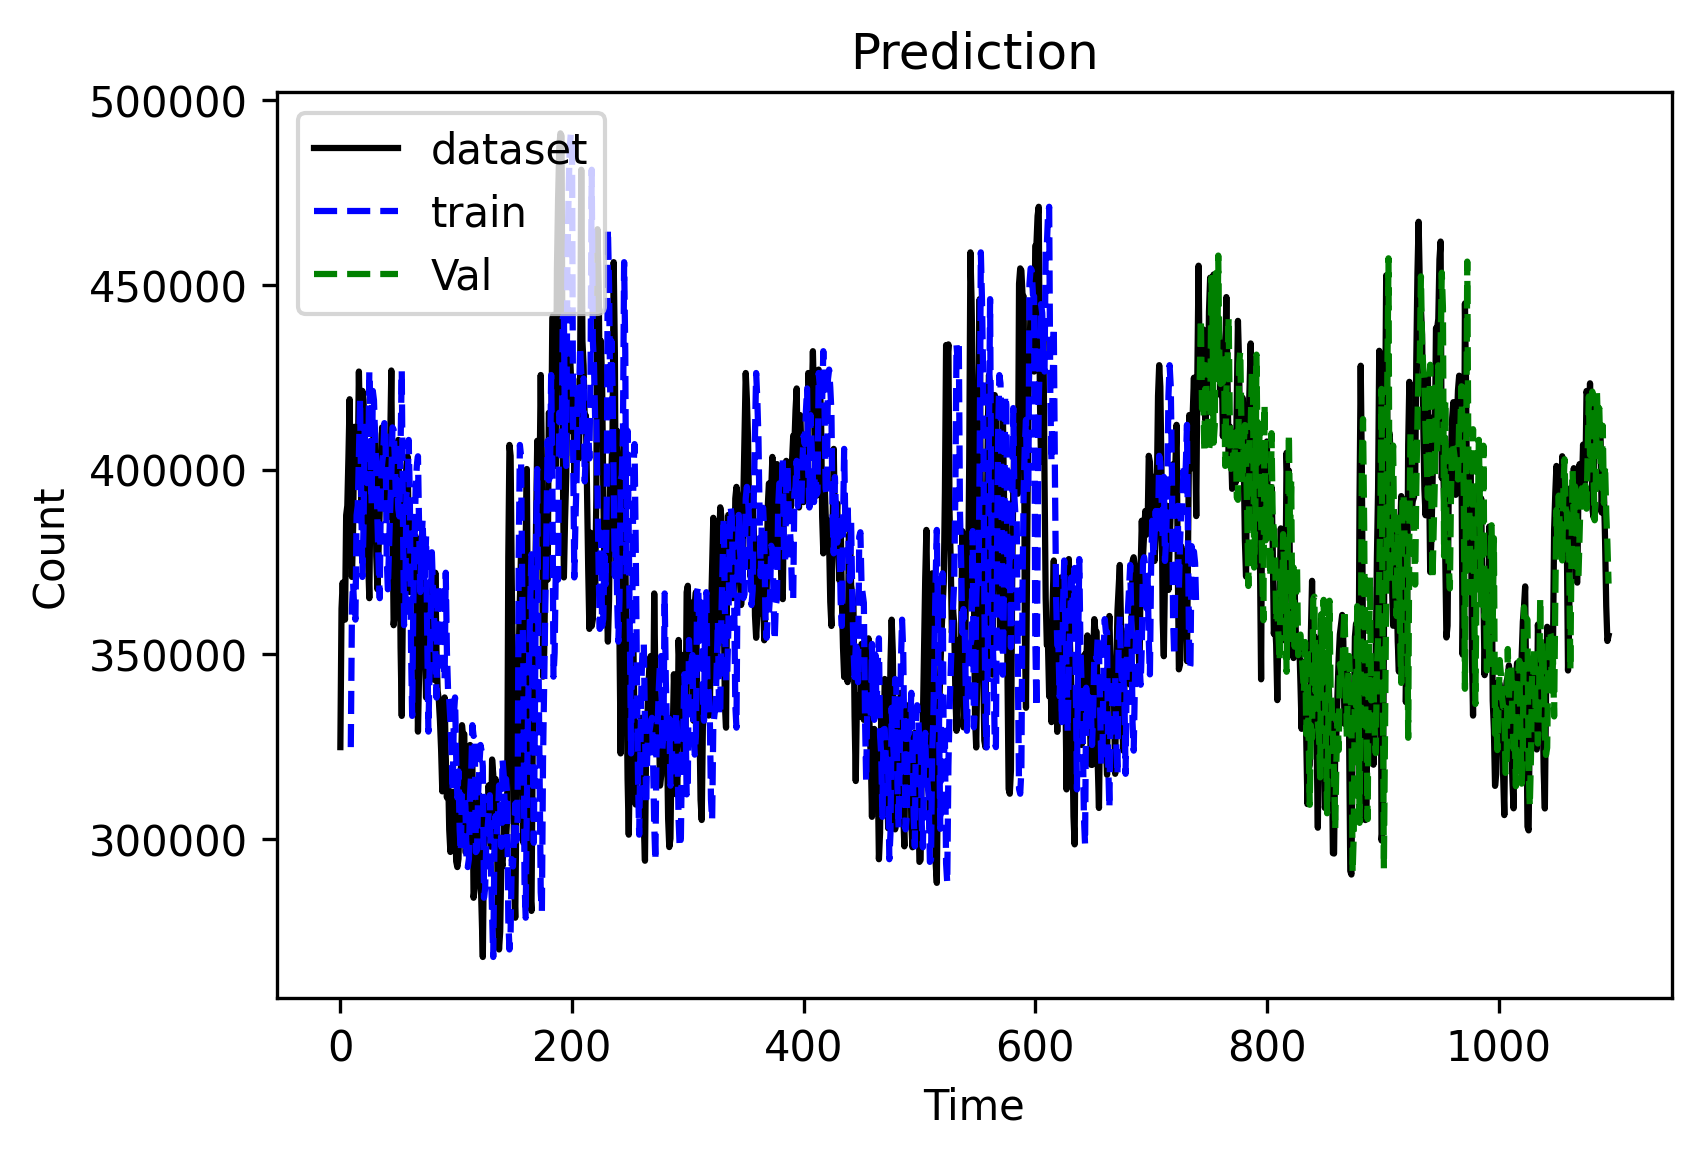

In [ ]:
plotting (dataset[:, 0].reshape(-1, 1), train[:, 0].reshape(-1, 1), prediction[:, 0].reshape(-1, 1))

In [ ]:
np.square(prediction[:, 0].reshape(-1, 1) - testY).mean()

329325202.3027696

In [ ]:
np.abs(prediction[:, 0].reshape(-1, 1) - testY).mean()

14334.84003961423

In [ ]:
def mape(x, y):
  error = abs(x-y)/abs(x)
  error[error > 1] = 1
  return np.mean(error)

mape(prediction[:, 0].reshape(-1, 1), testY)

0.03825991558717157